# States of waterpoints in Tanzania

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
data_path = 'data'
train_df = pd.read_csv(f'{data_path}/train.csv', index_col='id').join(
    pd.read_csv(f'{data_path}/train_labels.csv', index_col='id')
)

In [3]:
train_df.shape

(59400, 40)

## Target

In [4]:
train_df['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

## Numerical Features

In [5]:
num_cols = [col for col, dtype in train_df.dtypes.items() if dtype != 'object']

train_df[num_cols].sample(5)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
id,,,,,,,,,
56434,0.0,0,30.786329,-1.409235,0,18,1,0,0
49671,0.0,140,39.323219,-11.065947,0,90,33,1,1981
32832,0.0,0,33.002798,-2.675066,0,19,7,0,0
22442,0.0,0,31.761298,-1.284876,0,18,2,0,0
339,0.0,0,33.138688,-9.279612,0,12,2,0,0


### NaNs and zeros

In [6]:
train_df[num_cols].isna().sum().to_frame('# of NaNs')

,# of NaNs
amount_tsh,0
gps_height,0
longitude,0
latitude,0
num_private,0
region_code,0
district_code,0
population,0
construction_year,0


In [7]:
pd.DataFrame([
    {'feature': col, 'zero_pct': 100 * (train_df[col] == 0).mean()}
    for col in num_cols
]).set_index('feature').sort_values('zero_pct', ascending=False).round(1)

,zero_pct
feature,
num_private,98.7
amount_tsh,70.1
population,36.0
construction_year,34.9
gps_height,34.4
longitude,3.1
district_code,0.0
latitude,0.0
region_code,0.0


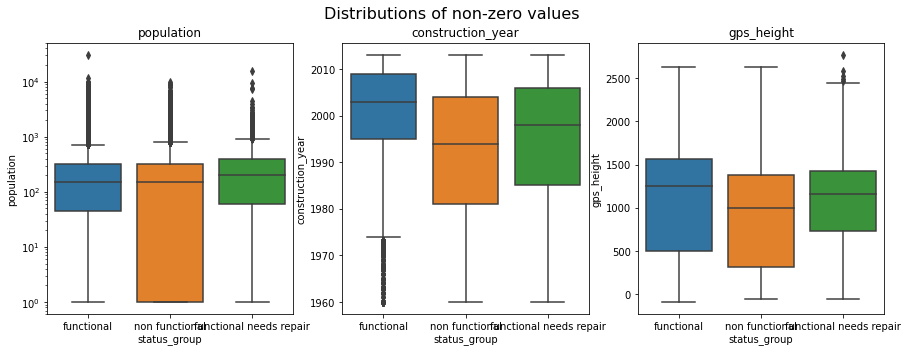

In [8]:
cols = ['population', 'construction_year', 'gps_height']

plt.figure(figsize=(15, 5))

plt.suptitle('Distributions of non-zero values', fontsize=16)

for i, col in enumerate(cols, start=1):
    plt.subplot((len(cols) + 1) // 3, 3, i)
    mask = train_df[col] != 0
    sns.boxplot(x=train_df[mask].status_group, y=train_df[mask][col])
    plt.title(col)
    if col == 'population':
        plt.yscale('log')
    
plt.show()

### `latitude, longitude`

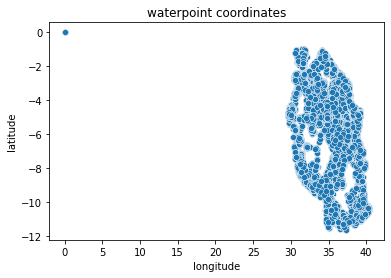

In [9]:
plt.title('waterpoint coordinates')
sns.scatterplot(x=train_df.longitude, y=train_df.latitude)
plt.show()

Let's impute the dots at $(0, 0)$ using their `lga` values and Google Maps.

In [10]:
train_df[train_df.longitude == 0]['lga'].unique()

array(['Bariadi', 'Geita', 'Magu'], dtype=object)

In [11]:
from sklearn.base import TransformerMixin
    
class LatLonImputer(TransformerMixin):
    
    def __init__(self):
        self.lga_latlon = {
            'Bariadi': (-2.807838, 33.988149),
            'Geita': (-2.878836, 32.227321),
            'Magu': (-2.591117, 33.439851),
        }
        
    def transform(self, df, y=None):
        X = df.copy()
        mask = X.longitude < 20
        for lga in X[mask].lga.unique():
            assert lga in self.lga_latlon, f'unknown lga: {lga}'
            lat, lon = self.lga_latlon[lga]
            X.loc[mask & (X.lga == lga), 'latitude'] = lat
            X.loc[mask & (X.lga == lga), 'longitude'] = lon
        return X
    
    def fit(self, df, y=None):
        return self

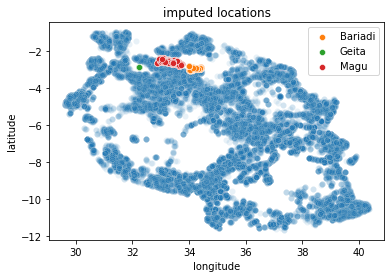

In [12]:
tmp = LatLonImputer().transform(train_df)
plt.title('imputed locations')
sns.scatterplot(x=tmp.longitude, y=tmp.latitude, alpha=0.1)
for lga in train_df[train_df.longitude < 20].lga.unique():
    lga_df = tmp[tmp.lga == lga]
    sns.scatterplot(x=lga_df.longitude, y=lga_df.latitude, label=lga)
plt.legend()
plt.show()

## Training

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

In [14]:
class NanStringImputer(TransformerMixin):
    
    def transform(self, df, y=None):
        X = df.copy()
        obj_cols = [col for col, dtype in df.dtypes.items() if dtype == 'object']
        for col in obj_cols:
            X.loc[X[col].isna(), col] = 'nan'
        return X
    
    def fit(self, df, y=None):
        return self

In [15]:
feature_pipeline = make_pipeline(
    LatLonImputer(),
    NanStringImputer(),
)

In [16]:
train = train_df.copy()

train = feature_pipeline.transform(train)

In [17]:
from catboost import CatBoostClassifier, Pool, cv

In [18]:
num_features = [
    'latitude', 'longitude', 'gps_height',
    'population', 'amount_tsh',
]

cat_features = [
    'funder', 'installer',
    'basin', 'subvillage', 'region', 'lga', 'ward',
    'public_meeting', 'permit',
    'extraction_type', 'extraction_type_group', 'extraction_type_class',
    'payment', 'payment_type',
    'water_quality',
    'quality_group', 'quantity', 'quantity_group',
    'source', 'source_type', 'source_class',
    'waterpoint_type', 'waterpoint_type_group',
]

features = num_features + cat_features

train_pool = Pool(
    data=train[features],
    label=train['status_group'],
    cat_features=cat_features,
)

In [19]:
model = CatBoostClassifier(iterations=150, random_state=0, custom_metric=['Accuracy'],
                           learning_rate=0.1, depth=9, l2_leaf_reg=11)

grid = {
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [3, 6, 9],
    'l2_leaf_reg': [7, 10, 13]
}

grid_search_result = model.grid_search(grid, X=train_pool, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6286138859
bestIteration = 149


bestTest = 0.581441361
bestIteration = 149


bestTest = 0.5568578483
bestIteration = 147


bestTest = 0.6288752934
bestIteration = 149


bestTest = 0.5826537191
bestIteration = 149


bestTest = 0.5611167306
bestIteration = 149


bestTest = 0.628912769
bestIteration = 149


bestTest = 0.5834765454
bestIteration = 149


bestTest = 0.5594053539
bestIteration = 149


bestTest = 0.5969241487
bestIteration = 149


bestTest = 0.5524284816
bestIteration = 149


bestTest = 0.5276210292
bestIteration = 149


bestTest = 0.5974351532
bestIteration = 149


bestTest = 0.5518133441
bestIteration = 149


bestTest = 0.5291257601
bestIteration = 147


bestTest = 0.5989962006
bestIteration = 149


bestTest = 0.5535168061
bestIteration = 149


bestTest = 0.5307266899
bestIteration = 149


bestTest = 0.5757269753
bestIteration = 149


bestTest = 0.5271285622
bestIteration = 149


bestTest = 0.509644299
bestIteration = 149


bestTest = 0.5784740027
bestIteratio

In [20]:
params = dict(
    iterations=350,
    learning_rate=0.1,
    depth=9,
    l2_leaf_reg=10,
    loss_function='MultiClass',
    custom_metric=['Accuracy'],
)

scores = cv(
    train_pool,
    params,
    fold_count=4, 
    plot="True",
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [21]:
model = CatBoostClassifier(iterations=500, random_state=0,
                           learning_rate=0.1, depth=9, l2_leaf_reg=10,
                           early_stopping_rounds=50, custom_metric=['Accuracy'])
model.fit(train_pool, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Submission

In [22]:
test_df = pd.read_csv(f'{data_path}/test.csv')

test_df = feature_pipeline.transform(test_df)

test_df['status_group'] = model.predict(test_df[features]).ravel()

In [23]:
submission = test_df[['id', 'status_group']].set_index('id')
submission.to_csv('submission.csv')

In [24]:
submission.head(5)

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional
